# **Team Assignment - Football ⚽ Database** 


For our team assignment we are interested in evaluating how well individual player ratings in FIFA predict actual soccer/football game outcomes. 

In particular, we want to compare different player attributes, different team ratings, and different cumulative player ratings across teams, to see what aspects of FIFA's rating system is most correlated with live game outcomes.

![alt text](https://drive.google.com/uc?id=1fifQTfEO90M51LcRGeNv_4NIgxa8daMq) 

Our dataset is the "European Soccer Database", and was sourced from Kaggle. It includes the following data for our analysis:  


*   Over 25,000 historical matches from the 2008 - 2016 seasons
*  Match details, including scoring, possesion, corners, fouls, etc.  
*   Attributes of over 10,000 players (from EA sports FIFA game series), team lineup, and squad formation
*   Betting odds from multiple betting providers





In [93]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
# Importing libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import sqlite3
import datetime as dt
from itertools import cycle, islice
from pandas.plotting import parallel_coordinates
from itertools import cycle, islice
from pandas.plotting import parallel_coordinates
from sklearn.cluster import KMeans
# Importing sqlite database
conn = sqlite3.connect('/content/drive/Shared drives/IS 833/database.sqlite')

We used the code below to identify the different tables present in the database above. 

In [95]:
#Connection for SQL commands
cursor = conn.cursor()
cursor.execute("SELECT name FROM sqlite_master WHERE type='table';")
#All tables in file 
print(cursor.fetchall())

[('sqlite_sequence',), ('Player_Attributes',), ('Player',), ('Match',), ('League',), ('Country',), ('Team',), ('Team_Attributes',)]


We then used the output to store each table in a dataframe below.

In [0]:
#Store each table in a DataFrame
df_league = pd.read_sql_query("select * from League;", conn)
df_player_attributes = pd.read_sql_query("select * from Player_Attributes;", conn)
df_player = pd.read_sql_query("select * from Player;", conn)
df_match = pd.read_sql_query("select * from Match;", conn)
df_country = pd.read_sql_query("select * from Country;", conn)
df_team_attributes = pd.read_sql_query("select * from Team_Attributes;", conn)
df_team = pd.read_sql_query("select * from Team;", conn)

We used this block of code (below) to view the information stored in each dataframe in order to determine what information we wanted to use for the project.

In [97]:
 df_player_attributes.head(1)
# df_team_attributes.tail(10)
# df_country.head(1)
# df_league.head(15)
# df_match.tail(10)
# df_team.head(1)
# df_player.head(1)
# df_player.info()
# df_player['birthday'][1]

,id,player_fifa_api_id,player_api_id,date,overall_rating,potential,preferred_foot,attacking_work_rate,defensive_work_rate,crossing,finishing,heading_accuracy,short_passing,volleys,dribbling,curve,free_kick_accuracy,long_passing,ball_control,acceleration,sprint_speed,agility,reactions,balance,shot_power,jumping,stamina,strength,long_shots,aggression,interceptions,positioning,vision,penalties,marking,standing_tackle,sliding_tackle,gk_diving,gk_handling,gk_kicking,gk_positioning,gk_reflexes
0,1,218353,505942,2016-02-18 00:00:00,67.0,71.0,right,medium,medium,49.0,44.0,71.0,61.0,44.0,51.0,45.0,39.0,64.0,49.0,60.0,64.0,59.0,47.0,65.0,55.0,58.0,54.0,76.0,35.0,71.0,70.0,45.0,54.0,48.0,65.0,69.0,69.0,6.0,11.0,10.0,8.0,8.0


This is a loop to figure out the age of the all the players based on the birthdate given in the data set. We did this to use the ages of players in future analyses to check the correlation between age of a player and the overall rating.

In [0]:
pd.options.mode.chained_assignment = None  # default='warn'
df_player['age']=df_player['birthday']
for i in range(len(df_player['birthday'])):
    today = dt.date.today()
    df_player['birthday'] = pd.to_datetime(df_player['birthday'])
    df_player['age'][i] = today.year - df_player['birthday'][i].year - ((today.month, today.day) < (df_player['birthday'][i].month, df_player['birthday'][i].day))

In [99]:
#merging the age of each player into the player attributes df

df_playerattr_justincase = pd.merge(df_player_attributes, df_player[['player_api_id','age']],on='player_api_id', how='left')
df_playerattr_justincase.head(1)

,id,player_fifa_api_id,player_api_id,date,overall_rating,potential,preferred_foot,attacking_work_rate,defensive_work_rate,crossing,finishing,heading_accuracy,short_passing,volleys,dribbling,curve,free_kick_accuracy,long_passing,ball_control,acceleration,sprint_speed,agility,reactions,balance,shot_power,jumping,stamina,strength,long_shots,aggression,interceptions,positioning,vision,penalties,marking,standing_tackle,sliding_tackle,gk_diving,gk_handling,gk_kicking,gk_positioning,gk_reflexes,age
0,1,218353,505942,2016-02-18 00:00:00,67.0,71.0,right,medium,medium,49.0,44.0,71.0,61.0,44.0,51.0,45.0,39.0,64.0,49.0,60.0,64.0,59.0,47.0,65.0,55.0,58.0,54.0,76.0,35.0,71.0,70.0,45.0,54.0,48.0,65.0,69.0,69.0,6.0,11.0,10.0,8.0,8.0,28


## Data Cleaning ✨

**Here, we cleaned the dataframes that we planned on using by dropping null values and deleted columns that we didn't plan on using**

In [100]:
#Keeping only the fields we wanted to use in player DataFrame
df_player = df_player.dropna()
df_player = df_player[['player_api_id', 'player_name', 'age']] #dropped height, weight, and fifa id
df_player.isna().sum()

player_api_id    0
player_name      0
age              0
dtype: int64

In [101]:
#Keeping only the fields we wanted to use in player_attributes DataFrame
df_playerattr = df_player_attributes #Creating this DataFrame to use later in machine learning
df_player_attributes = df_player_attributes[[ 'player_api_id', 'date', 'overall_rating']] #Keeping only the three attributes to use in our Team Ratings functions
df_playerattr = df_playerattr.dropna()
df_playerattr.isna().sum()

id                     0
player_fifa_api_id     0
player_api_id          0
date                   0
overall_rating         0
potential              0
preferred_foot         0
attacking_work_rate    0
defensive_work_rate    0
crossing               0
finishing              0
heading_accuracy       0
short_passing          0
volleys                0
dribbling              0
curve                  0
free_kick_accuracy     0
long_passing           0
ball_control           0
acceleration           0
sprint_speed           0
agility                0
reactions              0
balance                0
shot_power             0
jumping                0
stamina                0
strength               0
long_shots             0
aggression             0
interceptions          0
positioning            0
vision                 0
penalties              0
marking                0
standing_tackle        0
sliding_tackle         0
gk_diving              0
gk_handling            0
gk_kicking             0


In [102]:
#Keeping only the fields we wanted to use in team_attributes DataFrame
df_team_attributes = df_team_attributes[['id', 'team_api_id', 'date']] #dropped a lot of fifa attributes that we aren't using
df_team_attributes.isna().sum()

id             0
team_api_id    0
date           0
dtype: int64

In [103]:
#Keeping only the important fields in match DataFrame
df_match.isna().sum()
df_match = df_match[['country_id', 'league_id', 'season', 'stage', 'date', 'match_api_id', 'home_team_goal', 'away_team_goal', 'home_player_1',
       'home_player_2', 'home_player_3', 'home_player_4', 'home_player_5','home_player_6', 'home_player_7', 'home_player_8', 'home_player_9',
       'home_player_10', 'home_player_11', 'away_player_1', 'away_player_2','away_player_3', 'away_player_4', 'away_player_5', 'away_player_6',
       'away_player_7', 'away_player_8', 'away_player_9', 'away_player_10','away_player_11']]
df_match.isna().sum()

country_id           0
league_id            0
season               0
stage                0
date                 0
match_api_id         0
home_team_goal       0
away_team_goal       0
home_player_1     1224
home_player_2     1315
home_player_3     1281
home_player_4     1323
home_player_5     1316
home_player_6     1325
home_player_7     1227
home_player_8     1309
home_player_9     1273
home_player_10    1436
home_player_11    1555
away_player_1     1234
away_player_2     1278
away_player_3     1293
away_player_4     1321
away_player_5     1335
away_player_6     1313
away_player_7     1235
away_player_8     1341
away_player_9     1328
away_player_10    1441
away_player_11    1554
dtype: int64

In [104]:
#Keeping only the fields we wanted to use in team DataFrame
df_team.isna().sum()
df_team = df_team[['id', 'team_api_id', 'team_long_name']]
df_team.isna().sum()

id                0
team_api_id       0
team_long_name    0
dtype: int64

In [105]:
#Merging Country and League DataFrames
df_league_country =  pd.merge(df_country, df_league, on="id") #Merging on id column
df_league_country.rename(columns={'name_x': 'Country', 'name_y': 'League_Name'}, inplace= True) #Country and League shared the same column 'name', renaming here
df_league_country = df_league_country.drop('country_id', axis=1) #dropping the duplicate id column
df_league_country.head()

,id,Country,League_Name
0,1,Belgium,Belgium Jupiler League
1,1729,England,England Premier League
2,4769,France,France Ligue 1
3,7809,Germany,Germany 1. Bundesliga
4,10257,Italy,Italy Serie A


##Evaluating Predictions for Match Outcomes
Below is a series of functions that provide various options for evaluating predicted match outcomes. They include: 
  - Team Rating Comparison 
  - Win Probability (excluding chance of a draw)
  - Outcome Probability 

These plots are shown for any given match, and are compared against the actual match outcome to evaluate accuracy. 

### Team Ratings

These functions work together to return team ratings for two teams for a given match. The team rating is calculated by summing each players' individual overall FIFA rating. These scores can be used to (or at least attempt to) predict the outcome of a match. 

The problem we faced when calling players' overall ratings is that each players' rating changes over time, so each player has multiple ratings in the database. In order to solve this problem we wrote a function to call the correct overall rating based on matching the rating of the player at the time the match was played. 

In [0]:
#Finding the right version of the player to use in the match for the team rating function below
def version(match,player):
  date = pd.to_datetime(df_match[df_match['match_api_id']==match]['date'])
  player_date=pd.to_datetime(df_player_attributes[df_player_attributes['player_api_id']==player]['date'])
  #return len(player_date)
  found=False
  for i in range(0,len(player_date)):
    #print(player_date.iloc[i]<date)
    if player_date.iloc[i]<date.iloc[0]:
      return i

In [0]:
#Returns the team rating for both teams given the match id
def team_ratings(match):
  team1=0
  team2=0
  for i in range(-22,-12): #Indexing team 1 players
    player_id=df_match[df_match['match_api_id']==match].iloc[0].iloc[i]
    player=df_player_attributes[df_player_attributes['player_api_id']==player_id]
    player_ovr=player['overall_rating'].iloc[version(match,player_id)]
    team1=team1+player_ovr
  for i in range(-11,-1): #Indexing team 2 players
    player_id=df_match[df_match['match_api_id']==match].iloc[0].iloc[i]
    player=df_player_attributes[df_player_attributes['player_api_id']==player_id]
    player_ovr=player['overall_rating'].iloc[version(match,player_id)]
    team2=team2+player_ovr
  return [team1,team2] #Sum of overall ratings for both teams

**Plotting Team Rating:**
To display the results of the Team Rating comparison we are plotting a bar plot, which illustrates which team
has the higher cumulative rating, and is therefore more likely to win the match

In [0]:
# input for team_rating function (match api id)
outcome_team_rating = team_ratings(2030460)

# team_rating output displayed as a seaborn barplot visualization
def team_rating_plot(outcome_team_rating):
  df_outcome_tr = pd.DataFrame(outcome_team_rating).rename(columns={0: "team_rating"}, index={0: 'Home_team', 1: 'Away_team'})
  plt.figure()
  sns.set_style('darkgrid')
  plt.title('Predicted Match Outcome Based on Cumulative Player Ratings')
  plt.ylim(min(outcome_team_rating)-50, max(outcome_team_rating)+25) # y-axis values vary depending on the output of the team ratings
  sns.barplot(x=df_outcome_tr.index, y='team_rating', hue='team_rating', data=df_outcome_tr, palette='RdBu')
  plt.show()


###Evaluating Win Chance: 
As an alternative to viewing cumulative Team Rating as an indicator of match outcome, we created functions to calculate each team's Win Probability, both excluding and including the probability of a draw. 

In [0]:
def win_chance_no_draw(home, away):
  home_win=1/(1+10**(-(home-away+65)/400))
  away_win=1/(1+10**(-(away-home-65)/400))
  return [home_win,away_win]

**Plotting Win Probability:**
To display the results of the Win Probability we are plotting a pie plots, which illustrate the likelihood of outcome by percentage. We include both the Win Probability for Home and Away teams, as well as the overall match outcome probabilities. 

In [0]:
# input for win_chance_no_draw function (home team api id, away team api id)
outcome_win_chance_no_draw = win_chance_no_draw(8634, 8633)

# win_chance_no_draw output displayed as a matplotlib pieplot visualization
def win_chance_no_draw_plot(outcome_win_chance_no_draw):
  labels= 'Home Team', 'Away Team'
  explode= (0.05, 0.0)
  colors = ['#ffb3ba','#bae1ff'] 

  fig1, ax1 = plt.subplots()
  ax1.pie(outcome_win_chance_no_draw, explode=explode, labels=labels, colors=colors, autopct='%1.1f%%',
        shadow=True, startangle=90)
  ax1.axis('equal')  
  ax1.set_title("Win Probability for Match\n"+"(no chance of a draw)", fontsize=18)

###Evaluating Probability of Match Outcome: 
The win_chance funtion below builds on the previous function in that it compares the win probability between the Home and Away teams, but also includes the probability of a draw, displaying the overall probabilities for the match's outcome. 

In [0]:
def win_chance(match):
  home_win2=win_chance_no_draw(team_ratings(match)[0],team_ratings(match)[1])[0]**2
  away_win2=win_chance_no_draw(team_ratings(match)[0],team_ratings(match)[1])[1]**2
  draw=1-home_win2-away_win2
  return [home_win2, away_win2, draw]

**Plotting Probability of Match Outcome:**
Displaying the Match Outcome probabilities in a pie plot allows us to easily compare how the probability of a draw affects each team's win probability. 

In [0]:
# input for win_chance function (match api id)
outcome_win_chance = win_chance(2030460)

# win_chance output displayed as a matplotlib pieplot visualization
def win_chance_plot(outcome_win_chance):
  labels= 'Home Team', 'Away Team', 'Draw'
  if outcome_win_chance[0]>outcome_win_chance[1] and outcome_win_chance[0]>outcome_win_chance[2]:
    explode= (0.05, 0.0, 0.0)
  elif outcome_win_chance[1]>outcome_win_chance[0] and outcome_win_chance[1]>outcome_win_chance[2]:
    explode= (0.0, 0.05, 0.0)
  else:
    explode= (0.0, 0.0, 0.05)
  colors = ['#ffb3ba','#bae1ff', '#ffffba'] 

  fig2, ax2 = plt.subplots()
  ax2.pie(outcome_win_chance, explode=explode, labels=labels, colors=colors, autopct='%1.1f%%',
        shadow=True, startangle=90)
  ax2.axis('equal')  
  ax2.set_title("Win Probability for Match\n"+"(including chance of a draw)", fontsize= 18)

###Reporting Actual Match Result:
The below functions determine the actual outcome of a given match. The actual_result function compares the goals scored in each match to determine the actual match outcome. The match_points function then displays the league points assigned to each team. 

In [0]:
def actual_result(match):
  home_goal=df_match[df_match['match_api_id']==match]['home_team_goal']
  away_goal=df_match[df_match['match_api_id']==match]['away_team_goal']
  if home_goal.iloc[0]>away_goal.iloc[0]:
    return [1,0,0]
  elif home_goal.iloc[0]<away_goal.iloc[0]:
    return [0,1,0]
  else:
    return [0,0,1]

**Plotting Actual Match Results:**  We then plot the results in a pie plot to compare against the plot for the probabilities of the match outcome.

In [0]:
# inputs for actual_result function and match_points function
outcome_actual_result = actual_result(2030406)

def actual_result_plot(outcome_actual_result):
  labels= 'Home Team', 'Away Team', 'Draw'
# setting the explode parameter based off of the output values of the actual_result function
  if outcome_actual_result[0]>outcome_actual_result[1] and outcome_actual_result[0]>outcome_actual_result[2]:
    explode= (0.05, 0.0, 0.0)
  elif outcome_actual_result[1]>outcome_actual_result[0] and outcome_actual_result[1]>outcome_actual_result[2]:
    explode= (0.0, 0.05, 0.0)
  else:
    explode= (0.0, 0.0, 0.05)

# setting the color parameter based off of the output values of the actual_result function
  if outcome_actual_result[0]>outcome_actual_result[1] and outcome_actual_result[0]>outcome_actual_result[2]:
    colors = ['#8DDB76','#A7A7A7', '#A7A7A7'] 
  elif outcome_actual_result[1]>outcome_actual_result[0] and outcome_actual_result[1]>outcome_actual_result[2]:
    colors = ['#A7A7A7','#8DDB76', '#A7A7A7'] 
  else:
    colors = ['#A7A7A7','#A7A7A7', '#8DDB76'] 

  fig3, ax3 = plt.subplots()
  ax3.pie(outcome_win_chance, explode=explode, labels=labels, colors=colors, autopct='%1.1f%%',
        shadow=True, startangle=90)
  ax3.axis('equal')  
  ax3.set_title("Actual Match Outcome", fontsize= 18)

###Displaying our visualizations

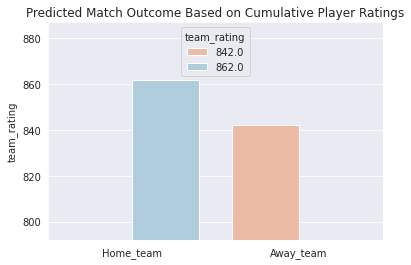

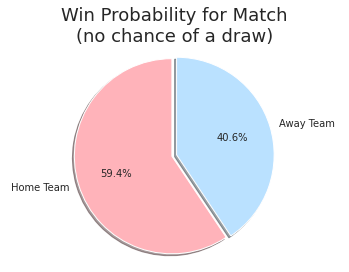

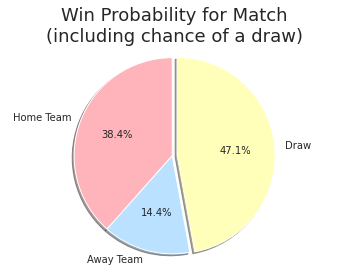

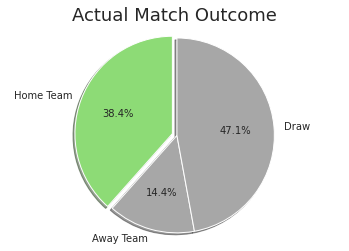

In [115]:
team_rating_plot(outcome_team_rating)
print(" ")
win_chance_no_draw_plot(outcome_win_chance_no_draw)
print(" ")
win_chance_plot(outcome_win_chance)
print(" ")
actual_result_plot(outcome_actual_result)

In [0]:
def match_points(match):
  home_points=win_chance(match)[0]*actual_result(match)[0]
  away_points=win_chance(match)[1]*actual_result(match)[1]
  draw_points=win_chance(match)[2]*actual_result(match)[2]
  total_points=home_points+away_points+draw_points
  return total_points

In [0]:
# #DO NOT RUN - WILL TAKE 7+ HOURS
# #If you want to run, reduce for loop length
# total_points=0
# total_matches=0
# match_id=df_match['match_api_id']
# #print(df_match[df_match['match_api_id']==match_id.iloc[i]])
# print(match_id.shape[0]) #25000+
# for i in range(0,match_id.shape[0]): #Reduce if you want to run
#   all_players=True
#   for j in range(-22,-1):
#     player_id=df_match[df_match['match_api_id']==match_id.iloc[i]].iloc[0].iloc[j]
#     if np.isnan(player_id):
#       all_players=False
#   #print(player_id)
#   #print(all_players)
#   if all_players==True:
#     #print(match_id[i])
#     total_points=total_points+match_points(match_id[i])#7592.23811852896
#     total_matches=total_matches+1#21374
#     #print(match_points(match_id[i]))
#   print(i)

The below function allows us to evaluate the predictive power of our model. We assign a score to each game. The score is based on the win probability that our model generated and the actual result of the match. We then determine a cumulative score of the model by summing all of the match scores and then taking the average. This outputs the average score for the first 500 matches.

In [118]:
#Reduced version of above
#Still takes a few minutes - Please be patient
total_points=0
total_matches=0
match_id=df_match['match_api_id']
for i in range(0,500): 
  all_players=True
  for j in range(-22,-1):
    player_id=df_match[df_match['match_api_id']==match_id.iloc[i]].iloc[0].iloc[j]
    if np.isnan(player_id):
      all_players=False  
  if all_players==True:
    total_points=total_points+match_points(match_id[i])
    total_matches=total_matches+1
print(total_points/total_matches)

0.35370910409219664


## Machine Learning

###Correlations

In [119]:
#Looking at correlations in the data
correlation_matrix  = df_playerattr.corr()
correlation_matrix["overall_rating"].sort_values(ascending=False)

overall_rating        1.000000
reactions             0.771856
potential             0.765435
short_passing         0.458243
ball_control          0.443991
long_passing          0.434525
vision                0.431493
shot_power            0.428053
penalties             0.392715
long_shots            0.392668
positioning           0.368978
volleys               0.361739
curve                 0.357566
crossing              0.357320
dribbling             0.354191
free_kick_accuracy    0.349800
finishing             0.330079
stamina               0.325606
aggression            0.322782
strength              0.315684
heading_accuracy      0.313324
jumping               0.258978
sprint_speed          0.253048
interceptions         0.249094
acceleration          0.243998
agility               0.239963
standing_tackle       0.163986
balance               0.160211
marking               0.132185
sliding_tackle        0.128054
gk_kicking            0.028799
gk_diving             0.027675
gk_posit

In [0]:
#Saving only the relevant correlations and omitting the three IDs
columns = ['reactions','potential','short_passing','ball_control','long_passing','vision','shot_power','penalties','long_shots','volleys','curve',
'dribbling','free_kick_accuracy','finishing','stamina','aggression','strength','heading_accuracy','jumping','sprint_speed','interceptions','acceleration',
'agility','standing_tackle','balance','marking','sliding_tackle','gk_kicking','gk_diving','gk_positioning','gk_reflexes','gk_handling']

In [0]:
#Creating a list of the correlations between overall rating and the rest of the attributes
correlations = [ df_playerattr['overall_rating'].corr(df_playerattr[i]) for i in columns ] 

In [0]:
#Function to plot the correlation list passing in the data frame and the y label 
def plot_dataframe(df, y_label):  
    fig = plt.gcf()
    fig.set_size_inches(12, 6) #setting a readable size for the plot
    plt.ylabel(y_label)
    ax = df.correlations.plot(linewidth=3.3, color='blue') #plotting the line
    ax.set_xticks(df.index)
    ax.set_xticklabels(df.column, rotation=65); 
    plt.show()

In [0]:
#Creating a DataFrame of just the correlations and the columns
df_plot = pd.DataFrame({'column': columns, 'correlations': correlations}) 

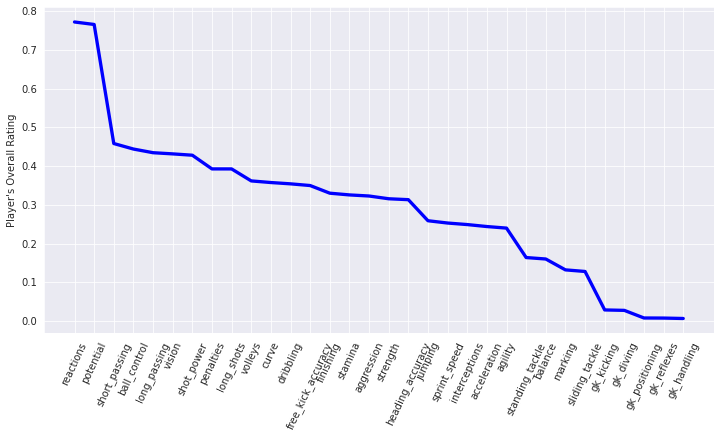

In [124]:
#Plotting using the above function
plot_dataframe(df_plot, 'Player\'s Overall Rating')

### Supervized Machine Learning  



####Predict Player's Overall Rating Based on Attributes (Lasso)

In [125]:
df_playerattr_justincase.head(1)

,id,player_fifa_api_id,player_api_id,date,overall_rating,potential,preferred_foot,attacking_work_rate,defensive_work_rate,crossing,finishing,heading_accuracy,short_passing,volleys,dribbling,curve,free_kick_accuracy,long_passing,ball_control,acceleration,sprint_speed,agility,reactions,balance,shot_power,jumping,stamina,strength,long_shots,aggression,interceptions,positioning,vision,penalties,marking,standing_tackle,sliding_tackle,gk_diving,gk_handling,gk_kicking,gk_positioning,gk_reflexes,age
0,1,218353,505942,2016-02-18 00:00:00,67.0,71.0,right,medium,medium,49.0,44.0,71.0,61.0,44.0,51.0,45.0,39.0,64.0,49.0,60.0,64.0,59.0,47.0,65.0,55.0,58.0,54.0,76.0,35.0,71.0,70.0,45.0,54.0,48.0,65.0,69.0,69.0,6.0,11.0,10.0,8.0,8.0,28


In [126]:
#dropping columns with no predictive power

df_player_attributes_ml = df_playerattr_justincase.drop(['id', 'player_fifa_api_id', 'player_api_id', 'date'], axis=1)
df_player_attributes_ml.head(1)

,overall_rating,potential,preferred_foot,attacking_work_rate,defensive_work_rate,crossing,finishing,heading_accuracy,short_passing,volleys,dribbling,curve,free_kick_accuracy,long_passing,ball_control,acceleration,sprint_speed,agility,reactions,balance,shot_power,jumping,stamina,strength,long_shots,aggression,interceptions,positioning,vision,penalties,marking,standing_tackle,sliding_tackle,gk_diving,gk_handling,gk_kicking,gk_positioning,gk_reflexes,age
0,67.0,71.0,right,medium,medium,49.0,44.0,71.0,61.0,44.0,51.0,45.0,39.0,64.0,49.0,60.0,64.0,59.0,47.0,65.0,55.0,58.0,54.0,76.0,35.0,71.0,70.0,45.0,54.0,48.0,65.0,69.0,69.0,6.0,11.0,10.0,8.0,8.0,28


In [127]:
#checking the number of null values

df_player_attributes_ml.isnull().sum()

overall_rating          836
potential               836
preferred_foot          836
attacking_work_rate    3230
defensive_work_rate     836
crossing                836
finishing               836
heading_accuracy        836
short_passing           836
volleys                2713
dribbling               836
curve                  2713
free_kick_accuracy      836
long_passing            836
ball_control            836
acceleration            836
sprint_speed            836
agility                2713
reactions               836
balance                2713
shot_power              836
jumping                2713
stamina                 836
strength                836
long_shots              836
aggression              836
interceptions           836
positioning             836
vision                 2713
penalties               836
marking                 836
standing_tackle         836
sliding_tackle         2713
gk_diving               836
gk_handling             836
gk_kicking          

In [0]:
#dropping null values

df_player_attributes_ml = df_player_attributes_ml.dropna()

In [129]:
#making sure all null values are dropped

df_player_attributes_ml.isnull().sum()

overall_rating         0
potential              0
preferred_foot         0
attacking_work_rate    0
defensive_work_rate    0
crossing               0
finishing              0
heading_accuracy       0
short_passing          0
volleys                0
dribbling              0
curve                  0
free_kick_accuracy     0
long_passing           0
ball_control           0
acceleration           0
sprint_speed           0
agility                0
reactions              0
balance                0
shot_power             0
jumping                0
stamina                0
strength               0
long_shots             0
aggression             0
interceptions          0
positioning            0
vision                 0
penalties              0
marking                0
standing_tackle        0
sliding_tackle         0
gk_diving              0
gk_handling            0
gk_kicking             0
gk_positioning         0
gk_reflexes            0
age                    0
dtype: int64

In [130]:
#checking the variable types to see which ones need to be converted to dummies

df_player_attributes_ml.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 180354 entries, 0 to 183977
Data columns (total 39 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   overall_rating       180354 non-null  float64
 1   potential            180354 non-null  float64
 2   preferred_foot       180354 non-null  object 
 3   attacking_work_rate  180354 non-null  object 
 4   defensive_work_rate  180354 non-null  object 
 5   crossing             180354 non-null  float64
 6   finishing            180354 non-null  float64
 7   heading_accuracy     180354 non-null  float64
 8   short_passing        180354 non-null  float64
 9   volleys              180354 non-null  float64
 10  dribbling            180354 non-null  float64
 11  curve                180354 non-null  float64
 12  free_kick_accuracy   180354 non-null  float64
 13  long_passing         180354 non-null  float64
 14  ball_control         180354 non-null  float64
 15  acceleration     

In [0]:
#getting dummies on variables and dropping the first

df_player_attributes_ml = pd.get_dummies(df_player_attributes_ml, columns=['preferred_foot', 'attacking_work_rate', 'defensive_work_rate'], drop_first=True)


In [132]:
#checking new columns after dummeis

df_player_attributes_ml.head(1)

,overall_rating,potential,crossing,finishing,heading_accuracy,short_passing,volleys,dribbling,curve,free_kick_accuracy,long_passing,ball_control,acceleration,sprint_speed,agility,reactions,balance,shot_power,jumping,stamina,strength,long_shots,aggression,interceptions,positioning,vision,penalties,marking,standing_tackle,sliding_tackle,gk_diving,gk_handling,gk_kicking,gk_positioning,gk_reflexes,age,preferred_foot_right,attacking_work_rate_high,attacking_work_rate_le,attacking_work_rate_low,attacking_work_rate_medium,attacking_work_rate_norm,attacking_work_rate_stoc,attacking_work_rate_y,defensive_work_rate_1,defensive_work_rate_2,defensive_work_rate_3,defensive_work_rate_4,defensive_work_rate_5,defensive_work_rate_6,defensive_work_rate_7,defensive_work_rate_8,defensive_work_rate_9,defensive_work_rate_ean,defensive_work_rate_es,defensive_work_rate_high,defensive_work_rate_low,defensive_work_rate_medium,defensive_work_rate_o,defensive_work_rate_ormal,defensive_work_rate_tocky
0,67.0,71.0,49.0,44.0,71.0,61.0,44.0,51.0,45.0,39.0,64.0,49.0,60.0,64.0,59.0,47.0,65.0,55.0,58.0,54.0,76.0,35.0,71.0,70.0,45.0,54.0,48.0,65.0,69.0,69.0,6.0,11.0,10.0,8.0,8.0,28,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0


In [133]:
#checking to make sure data types will work with lasso regression

df_player_attributes_ml.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 180354 entries, 0 to 183977
Data columns (total 61 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   overall_rating              180354 non-null  float64
 1   potential                   180354 non-null  float64
 2   crossing                    180354 non-null  float64
 3   finishing                   180354 non-null  float64
 4   heading_accuracy            180354 non-null  float64
 5   short_passing               180354 non-null  float64
 6   volleys                     180354 non-null  float64
 7   dribbling                   180354 non-null  float64
 8   curve                       180354 non-null  float64
 9   free_kick_accuracy          180354 non-null  float64
 10  long_passing                180354 non-null  float64
 11  ball_control                180354 non-null  float64
 12  acceleration                180354 non-null  float64
 13  sprint_speed  

In [134]:
#setting up X variable equal to everything other than our target

X = df_player_attributes_ml.drop(['overall_rating'], axis=1)
df_player_attributes_ml.shape, X.shape

((180354, 61), (180354, 60))

In [135]:
#setting up target variable 

y = df_player_attributes_ml['overall_rating']
y.shape

(180354,)

In [0]:
#importing necessary packages 

from sklearn.linear_model import Lasso
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression

In [0]:
#using train test split to segment the data

Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, test_size=0.01, random_state=5)

In [0]:
#defining Lasso and fitting it to the data

lasso = Lasso()
lasso.fit(Xtrain,ytrain)
train_score=lasso.score(Xtrain,ytrain)
test_score=lasso.score(Xtest,ytest)
coeff_used = np.sum(lasso.coef_!=0)

In [139]:
#running lasso regression and assingning it to variables for easy to read accuracy scores

lasso001 = Lasso(alpha=0.01, max_iter=10e5)
y_model= lasso001.fit(Xtrain,ytrain)
train_score001=lasso001.score(Xtrain,ytrain)
test_score001=lasso001.score(Xtest,ytest)
coeff_used001 = np.sum(lasso001.coef_!=0)
print("training score for alpha=0.01:", train_score001)
print("test score for alpha =0.01: ", test_score001)
print("number of features used: for alpha =0.01:", coeff_used001)



training score for alpha=0.01: 0.8692150191924483
test score for alpha =0.01:  0.8549245327929845
number of features used: for alpha =0.01: 39


In [0]:
#using the model to predict on data the model has not seen before
y_model = lasso001.predict(Xtest)

In [141]:
#absolute error on predicted overall rating and actual overall rating (in abosolute value)

from sklearn.metrics import mean_absolute_error
mean_absolute_error(ytest, y_model)

2.0281172272758354

In [142]:
#scroll all the way over to the right to compare true overall ratings and predicted overall ratings

test = Xtest.join(ytest).reset_index()
df_overall_rating_ml_result = test.join(pd.Series(y_model, name='predicted'))
df_overall_rating_ml_result.head(50)

,index,potential,crossing,finishing,heading_accuracy,short_passing,volleys,dribbling,curve,free_kick_accuracy,long_passing,ball_control,acceleration,sprint_speed,agility,reactions,balance,shot_power,jumping,stamina,strength,long_shots,aggression,interceptions,positioning,vision,penalties,marking,standing_tackle,sliding_tackle,gk_diving,gk_handling,gk_kicking,gk_positioning,gk_reflexes,age,preferred_foot_right,attacking_work_rate_high,attacking_work_rate_le,attacking_work_rate_low,attacking_work_rate_medium,attacking_work_rate_norm,attacking_work_rate_stoc,attacking_work_rate_y,defensive_work_rate_1,defensive_work_rate_2,defensive_work_rate_3,defensive_work_rate_4,defensive_work_rate_5,defensive_work_rate_6,defensive_work_rate_7,defensive_work_rate_8,defensive_work_rate_9,defensive_work_rate_ean,defensive_work_rate_es,defensive_work_rate_high,defensive_work_rate_low,defensive_work_rate_medium,defensive_work_rate_o,defensive_work_rate_ormal,defensive_work_rate_tocky,overall_rating,predicted
0,115363,77.0,11.0,8.0,21.0,33.0,18.0,9.0,10.0,9.0,33.0,27.0,45.0,43.0,49.0,73.0,66.0,29.0,67.0,45.0,77.0,11.0,64.0,23.0,14.0,43.0,18.0,8.0,8.0,9.0,74.0,67.0,60.0,73.0,75.0,38,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,72.0,74.918724
1,168611,73.0,51.0,31.0,72.0,65.0,44.0,35.0,37.0,36.0,67.0,58.0,27.0,33.0,39.0,72.0,58.0,61.0,76.0,62.0,75.0,43.0,73.0,75.0,25.0,55.0,53.0,75.0,74.0,76.0,14.0,9.0,7.0,10.0,5.0,40,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,73.0,71.403191
2,58448,68.0,66.0,44.0,59.0,64.0,23.0,55.0,59.0,39.0,57.0,71.0,75.0,77.0,78.0,72.0,71.0,67.0,74.0,86.0,66.0,58.0,87.0,60.0,59.0,58.0,50.0,54.0,58.0,69.0,7.0,9.0,9.0,12.0,12.0,34,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,67.0,67.702867
3,66947,80.0,75.0,59.0,68.0,76.0,56.0,74.0,54.0,21.0,70.0,75.0,82.0,83.0,74.0,78.0,69.0,73.0,83.0,78.0,70.0,67.0,75.0,68.0,64.0,70.0,42.0,73.0,75.0,73.0,10.0,14.0,6.0,5.0,6.0,32,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,74.0,76.833129
4,4966,71.0,43.0,58.0,75.0,67.0,27.0,29.0,30.0,46.0,62.0,62.0,51.0,55.0,43.0,63.0,52.0,52.0,78.0,55.0,84.0,47.0,72.0,67.0,46.0,41.0,59.0,69.0,72.0,68.0,8.0,8.0,13.0,7.0,15.0,39,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,71.0,70.505231
5,81174,64.0,63.0,63.0,50.0,69.0,62.0,60.0,54.0,68.0,67.0,73.0,62.0,62.0,58.0,57.0,50.0,64.0,57.0,84.0,73.0,64.0,57.0,29.0,36.0,73.0,62.0,43.0,52.0,44.0,12.0,12.0,5.0,7.0,13.0,37,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,62.0,65.021873
6,47916,67.0,51.0,44.0,32.0,49.0,50.0,66.0,44.0,42.0,39.0,61.0,67.0,72.0,71.0,47.0,51.0,59.0,49.0,61.0,57.0,30.0,29.0,21.0,44.0,33.0,52.0,16.0,18.0,17.0,9.0,8.0,5.0,11.0,5.0,29,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,53.0,57.347159
7,114968,85.0,83.0,77.0,54.0,81.0,70.0,77.0,84.0,78.0,79.0,81.0,81.0,83.0,85.0,72.0,78.0,77.0,65.0,79.0,61.0,72.0,70.0,48.0,79.0,76.0,57.0,25.0,22.0,26.0,11.0,6.0,7.0,5.0,9.0,32,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,80.0,77.752466
8,123863,73.0,47.0,36.0,79.0,46.0,31.0,36.0,44.0,30.0,49.0,61.0,34.0,34.0,31.0,64.0,34.0,58.0,73.0,69.0,83.0,21.0,84.0,75.0,22.0,53.0,52.0,72.0,75.0,74.0,11.0,15.0,13.0,8.0,11.0,36,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,73.0,69.218914
9,79504,85.0,67.0,54.0,35.0,64.0,59.0,83.0,72.0,53.0,66.0,79.0,91.0,86.0,91.0,70.0,79.0,69.0,53.0,66.0,34.0,66.0,44.0,22.0,64.0,70.0,62.0,27.0,25.0,24.0,14.0,11.0,8.0,10.0,8.0,26,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,74.0,72.052968


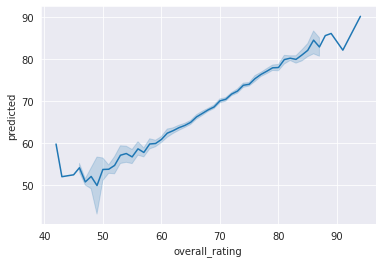

In [143]:
#Graphing the line between overall rating and predicited rating - shows that model is much better at predicitng ratings for players in middle of the of the pack
sns.lineplot(x='overall_rating', y='predicted', data=df_overall_rating_ml_result)
plt.show()

#### Predicting Player Age Based on Attributes

In [144]:
df_player_attributes_ml.head(1)

,overall_rating,potential,crossing,finishing,heading_accuracy,short_passing,volleys,dribbling,curve,free_kick_accuracy,long_passing,ball_control,acceleration,sprint_speed,agility,reactions,balance,shot_power,jumping,stamina,strength,long_shots,aggression,interceptions,positioning,vision,penalties,marking,standing_tackle,sliding_tackle,gk_diving,gk_handling,gk_kicking,gk_positioning,gk_reflexes,age,preferred_foot_right,attacking_work_rate_high,attacking_work_rate_le,attacking_work_rate_low,attacking_work_rate_medium,attacking_work_rate_norm,attacking_work_rate_stoc,attacking_work_rate_y,defensive_work_rate_1,defensive_work_rate_2,defensive_work_rate_3,defensive_work_rate_4,defensive_work_rate_5,defensive_work_rate_6,defensive_work_rate_7,defensive_work_rate_8,defensive_work_rate_9,defensive_work_rate_ean,defensive_work_rate_es,defensive_work_rate_high,defensive_work_rate_low,defensive_work_rate_medium,defensive_work_rate_o,defensive_work_rate_ormal,defensive_work_rate_tocky
0,67.0,71.0,49.0,44.0,71.0,61.0,44.0,51.0,45.0,39.0,64.0,49.0,60.0,64.0,59.0,47.0,65.0,55.0,58.0,54.0,76.0,35.0,71.0,70.0,45.0,54.0,48.0,65.0,69.0,69.0,6.0,11.0,10.0,8.0,8.0,28,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0


In [0]:
#setting up target variable

X = df_player_attributes_ml.drop(['age'], axis=1)
y = df_player_attributes_ml['age']


In [146]:

type(X), type(y)

(pandas.core.frame.DataFrame, pandas.core.series.Series)

In [147]:
#converting series to dataframe

y = pd.DataFrame(y)
type(y), type(X)


(pandas.core.frame.DataFrame, pandas.core.frame.DataFrame)

In [148]:
#making the dataframes the same number of columns 

X = X[:180350]
y = y[:180350]
X.shape, y.shape

((180350, 60), (180350, 1))

In [0]:
#running train test split on the data

Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, test_size = 0.3, random_state=5)

In [0]:
lasso = Lasso()
lasso.fit(Xtrain,ytrain)
train_score=lasso.score(Xtrain,ytrain)
test_score=lasso.score(Xtest,ytest)
coeff_used = np.sum(lasso.coef_!=0)

In [151]:
lasso001 = Lasso(alpha=0.000001, max_iter=10e8)
y_model= lasso001.fit(Xtrain,ytrain)
train_score001=lasso001.score(Xtrain,ytrain)
test_score001=lasso001.score(Xtest,ytest)
coeff_used001 = np.sum(lasso001.coef_!=0)
print("training score for alpha=0.01:", train_score001)
print("test score for alpha =0.01: ", test_score001)
print("number of features used: for alpha =0.01:", coeff_used001)



training score for alpha=0.01: 0.5791036094063107
test score for alpha =0.01:  0.5786695801799684
number of features used: for alpha =0.01: 58


In [0]:
y_model = lasso001.predict(Xtest)

In [153]:
#scroll all the way to the right to view actual age vs predicted age

test= Xtest.join(ytest).reset_index()
df_overall_rating_ml_result_2 = test.join(pd.Series(y_model, name='predicted'))
df_overall_rating_ml_result_2.head(20)

,index,overall_rating,potential,crossing,finishing,heading_accuracy,short_passing,volleys,dribbling,curve,free_kick_accuracy,long_passing,ball_control,acceleration,sprint_speed,agility,reactions,balance,shot_power,jumping,stamina,strength,long_shots,aggression,interceptions,positioning,vision,penalties,marking,standing_tackle,sliding_tackle,gk_diving,gk_handling,gk_kicking,gk_positioning,gk_reflexes,preferred_foot_right,attacking_work_rate_high,attacking_work_rate_le,attacking_work_rate_low,attacking_work_rate_medium,attacking_work_rate_norm,attacking_work_rate_stoc,attacking_work_rate_y,defensive_work_rate_1,defensive_work_rate_2,defensive_work_rate_3,defensive_work_rate_4,defensive_work_rate_5,defensive_work_rate_6,defensive_work_rate_7,defensive_work_rate_8,defensive_work_rate_9,defensive_work_rate_ean,defensive_work_rate_es,defensive_work_rate_high,defensive_work_rate_low,defensive_work_rate_medium,defensive_work_rate_o,defensive_work_rate_ormal,defensive_work_rate_tocky,age,predicted
0,115359,71.0,71.0,11.0,12.0,14.0,33.0,18.0,13.0,10.0,13.0,33.0,27.0,45.0,43.0,49.0,72.0,33.0,29.0,69.0,45.0,77.0,11.0,64.0,23.0,14.0,31.0,30.0,12.0,12.0,13.0,74.0,67.0,60.0,72.0,74.0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,38,37.101214
1,144785,61.0,70.0,44.0,38.0,42.0,69.0,29.0,54.0,58.0,48.0,68.0,66.0,65.0,64.0,74.0,63.0,78.0,42.0,67.0,56.0,56.0,45.0,43.0,54.0,59.0,66.0,51.0,38.0,50.0,39.0,14.0,11.0,8.0,6.0,12.0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,28,28.500028
2,58447,66.0,68.0,66.0,44.0,59.0,64.0,23.0,55.0,63.0,39.0,57.0,71.0,75.0,77.0,78.0,72.0,71.0,67.0,74.0,86.0,66.0,58.0,88.0,60.0,59.0,58.0,50.0,52.0,56.0,67.0,7.0,9.0,9.0,12.0,12.0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,34,33.292938
3,66946,75.0,80.0,77.0,59.0,68.0,76.0,56.0,74.0,54.0,21.0,70.0,77.0,84.0,85.0,74.0,78.0,69.0,73.0,83.0,78.0,70.0,67.0,75.0,69.0,66.0,70.0,42.0,75.0,75.0,74.0,10.0,14.0,6.0,5.0,6.0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,32,29.903602
4,4966,71.0,71.0,43.0,58.0,75.0,67.0,27.0,29.0,30.0,46.0,62.0,62.0,51.0,55.0,43.0,63.0,52.0,52.0,78.0,55.0,84.0,47.0,72.0,67.0,46.0,41.0,59.0,69.0,72.0,68.0,8.0,8.0,13.0,7.0,15.0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,39,36.310363
5,41251,77.0,87.0,74.0,50.0,68.0,72.0,56.0,69.0,62.0,42.0,58.0,76.0,86.0,84.0,76.0,76.0,80.0,70.0,74.0,79.0,75.0,41.0,66.0,70.0,75.0,68.0,76.0,76.0,79.0,80.0,5.0,22.0,58.0,22.0,22.0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,29,33.139861
6,52735,75.0,78.0,64.0,32.0,76.0,77.0,48.0,63.0,32.0,54.0,76.0,73.0,68.0,69.0,73.0,76.0,66.0,52.0,84.0,75.0,71.0,28.0,70.0,81.0,57.0,72.0,62.0,75.0,77.0,75.0,12.0,8.0,11.0,12.0,6.0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,31,34.267916
7,148923,49.0,65.0,44.0,29.0,44.0,49.0,39.0,49.0,37.0,30.0,43.0,45.0,66.0,62.0,55.0,49.0,65.0,48.0,55.0,53.0,55.0,36.0,50.0,40.0,48.0,47.0,42.0,39.0,39.0,44.0,12.0,8.0,11.0,14.0,11.0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,24,25.656795
8,136756,82.0,85.0,69.0,89.0,81.0,74.0,82.0,75.0,79.0,86.0,75.0,72.0,73.0,69.0,72.0,87.0,78.0,90.0,80.0,78.0,84.0,84.0,67.0,29.0,85.0,78.0,84.0,30.0,32.0,34.0,12.0,7.0,6.0,14.0,11.0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,36,34.686276
9,163904,62.0,62.0,57.0,66.0,66.0,60.0,51.0,64.0,60.0,51.0,40.0,63.0,51.0,54.0,46.0,55.0,48.0,66.0,57.0,34.0,71.0,63.0,48.0,20.0,59.0,64.0,65.0,25.0,24.0,22.0,5.0,5.0,7.0,12.0,14.0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,38,36.546494


In [154]:
#checking the r2

from sklearn.metrics import r2_score
r2_score(ytest, y_model)

0.5786695801799684

In [155]:
#mean absolute error 

mean_absolute_error(ytest, y_model)

2.424331599172193

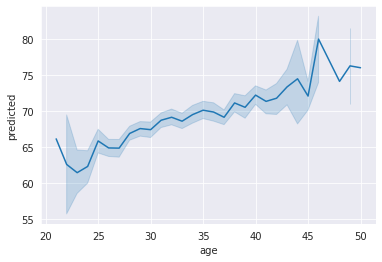

In [156]:
#graph shows that model is much better at predicting age of players between 25 ~ 40 years old 

sns.lineplot(x='age', y='predicted', data=df_overall_rating_ml_result)
plt.show()

#### Visualizing

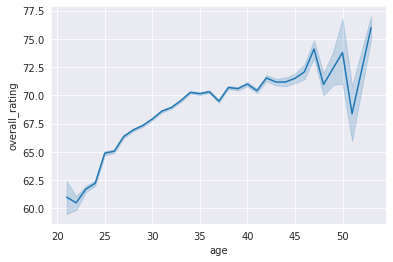

In [157]:
#showing the avereage players rating based on their age. Ratings for players 45+ seem unpredictable so checked the breakdown of number of players by age

sns.lineplot(x='age', y='overall_rating', data =df_playerattr_justincase)
plt.show()

In [158]:
#checking how many bins to create for the histogram

min(df_playerattr_justincase['age']), max(df_playerattr_justincase['age'])


(21, 53)

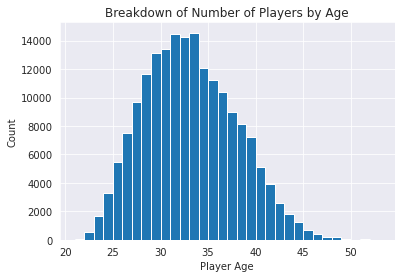

In [159]:
#checking number of players by age

plt.hist(x='age', bins=32, data=df_playerattr_justincase)
plt.xlabel("Player Age")
plt.ylabel("Count")
plt.title("Breakdown of Number of Players by Age")

plt.show()

###Dimensionality Reduction and Visualization

Here we will use principal component analysis (PCA), which is a fast linear dimensionality reduction technique. We will ask the model to return two components—that is, a two-dimensional representation of the data.

In [0]:
#Choosing four attributes we think correspong best to the four different types of players: Goalkeeper, Forward, Midfielder, Defender and storing in a DataFrame
df_mach_learn = df_playerattr[['gk_handling', 'finishing', 'short_passing', 'sliding_tackle']].copy(deep=True)
attr_corr = ['gk_handling', 'finishing', 'short_passing', 'sliding_tackle']

In [0]:
from sklearn.decomposition import PCA  # 1. Choose the model class
pca = PCA(n_components=2)              # 2. Instantiate the model with the number of components we want (2 here)
pca.fit(df_mach_learn)                        # 3. Fit to data. 
X_2D = pca.transform(df_mach_learn)           # 4. Transform the data

Plotting the results by inserting it back into the original df_playerattr DataFrame and using Seaborn to plot below:

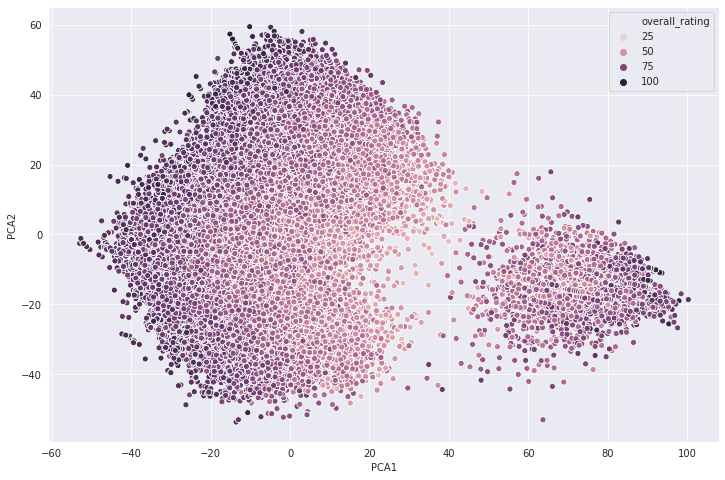

In [162]:
fig = plt.gcf()
fig.set_size_inches(12, 8)
df_playerattr['PCA1'] = X_2D[:, 0]
df_playerattr['PCA2'] = X_2D[:, 1]
sns.scatterplot("PCA1", "PCA2", hue='overall_rating', data=df_playerattr);

In [163]:
# What amount of variance does each PC explain?
pca.explained_variance_ratio_

array([0.48699213, 0.41072361])

In [164]:
# the most important features:
print(abs( pca.components_))

[[0.54406128 0.34133809 0.48828437 0.59081639]
 [0.13059045 0.71253989 0.16597793 0.66909219]]


###Unsupervized Machine Learning
From the above scatter plot we can see that there is a distinct break between two groups but overall rating does not seem to be the difference. We believe that the data is split corresponding to whether they are a goalkeeper, forward, midfielder, or defender. 

We are going to use an unsupervised machine learning method to determine the four clusters and determine which cluster represents which category of player. Note that we do not have a "true" sample, so this will serve as a way to determine what position a person should play given attribute values.

In [0]:
#Using the kmeans 
#data = scale(df_mach_learn) #standardizing
from sklearn.cluster import KMeans       # 1. Choose the model class
kmeans = KMeans(n_clusters=4, 
                random_state=833)        # 2. Instantiate the model with hyperparameters
kmeans.fit(df_mach_learn)                # 3. Fit to data
y_kmeans = kmeans.predict(df_mach_learn) # 4. Transform the data to two dimensions

In [0]:
df_playerattr['cluster'] = y_kmeans

In [167]:
#Counting the number of players in each cluster
pd.value_counts(kmeans.labels_, sort=False)

0    14609
1    49398
2    51281
3    65066
dtype: int64

In [168]:
kmeans.cluster_centers_

array([[66.29098501, 18.14956534, 28.03641591, 17.99753577],
       [11.4463895 , 56.49846017, 72.24683929, 64.88951698],
       [11.50145937, 31.75060321, 59.88560476, 65.83193882],
       [11.56624152, 66.54859455, 64.87516347, 27.90030309]])

In [169]:
centers = pca.transform(kmeans.cluster_centers_)
centers

array([[ 72.81345868, -14.86601019],
       [-19.40711037,  -4.41581651],
       [ -5.45076359, -24.7391026 ],
       [  2.68091087,  26.25531245]])

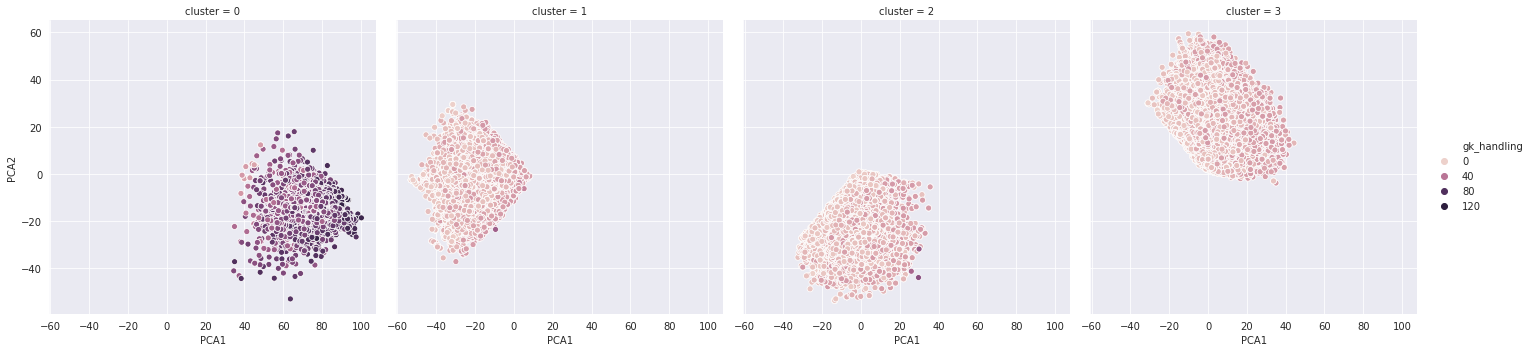

In [170]:
sns.relplot("PCA1", "PCA2", data=df_playerattr, hue='gk_handling', col='cluster', col_order=[0,1,2,3]);

This shows that cluster 0 are the goalkeepers and the other clusters are not. Repeating this process using the other hues, we can figure out that Cluster 0, 1, 2, and 3 are Goalkeepers, midfielders, defenders, and forwards respectively.

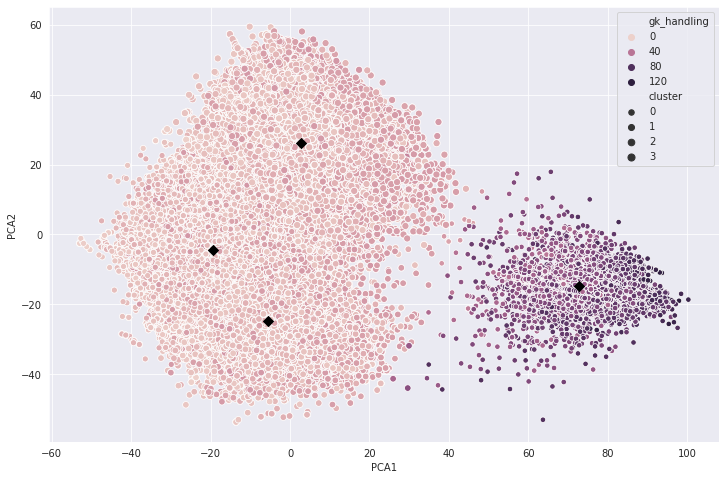

In [171]:
fig = plt.gcf()
fig.set_size_inches(12, 8)
sns.scatterplot("PCA1", "PCA2", data=df_playerattr, hue='gk_handling', size='cluster', sizes=(30,50));
plt.scatter(centers[:, 0], centers[:, 1], color='black', s=50, marker='D');

The above is another combined representation of the same.

In [0]:
def pd_centers(featuresUsed, centers):
    colNames = list(featuresUsed)
    colNames.append('prediction')
    # Zip with a column called 'prediction' (index)
    Z = [np.append(A, index) for index, A in enumerate(centers)]
    
    # Convert to pandas for plotting
    P = pd.DataFrame(Z, columns=colNames)
    P['prediction'] = P['prediction'].astype(int)
    return P

In [0]:
def parallel_plot(data):
    line_colours = list(islice(cycle(['b', 'r', 'g', 'y']), None, len(data)))
    plt.figure(figsize=(15,8)).gca().axes.set_ylim([0,+80.5])
    parallel_coordinates(data, 'prediction', color = line_colours, marker='o')

In [174]:
final = pd_centers(featuresUsed=attr_corr, centers=kmeans.cluster_centers_)
final

,gk_handling,finishing,short_passing,sliding_tackle,prediction
0,66.290985,18.149565,28.036416,17.997536,0
1,11.446389,56.498460,72.246839,64.889517,1
2,11.501459,31.750603,59.885605,65.831939,2
3,11.566242,66.548595,64.875163,27.900303,3


This parallel plot shows an easier visualization of the interconnectivity of the 4 clusters and that 1 cluster is always on top for any given attribute


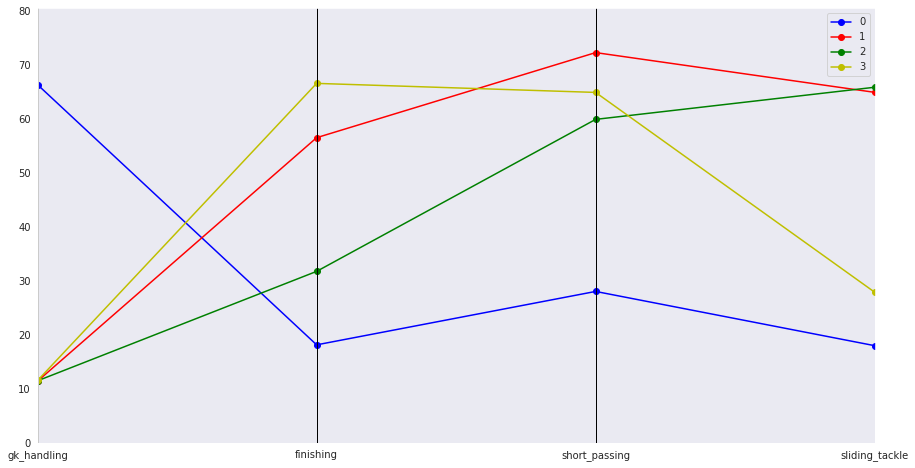

In [175]:
%matplotlib inline 
parallel_plot(final)